In [89]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
import librosa as lb
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [144]:
# retrieving of the targets

label_emotion = []

for file in os.listdir('./AudioWAV/') :
    part=file.split('_')
    if part[2] == 'SAD':
        label_emotion.append('sad')
    elif part[2] == 'ANG':
        label_emotion.append('angry')
    elif part[2] == 'DIS':
        label_emotion.append('disgust')
    elif part[2] == 'FEA':
        label_emotion.append('fear')
    elif part[2] == 'HAP':
        label_emotion.append('happy')
    elif part[2] == 'NEU':
        label_emotion.append('neutral')
    else:
        label_emotion.append('Unknown')

In [140]:
# Feature extraction

def extract_feature(X, sample_rate):

  result = np.array([])
  #MFCC
  mfcc = np.mean(lb.feature.mfcc(X, sr=sample_rate).T,axis = 0);
  result = np.hstack((result,mfcc))

  #Chroma
  stft = np.abs(lb.stft(X))
  chroma = np.mean(lb.feature.chroma_stft(S=stft, sr = sample_rate).T,axis=0)
  result = np.hstack((result,chroma))
  #Mel
  mel = np.mean(lb.feature.melspectrogram(X, sr = sample_rate).T,axis=0);
  result = np.hstack((result,mel))

  return result

In [142]:
%%capture --no-display

# extracting features for each audio file creating our samples

speech_list = []
for file in os.listdir('./AudioWAV/') :
    audio, sample_rate = lb.load('./AudioWAV/'+file)
    speech_list.append(extract_feature(audio,sample_rate))


<AxesSubplot: ylabel='count'>

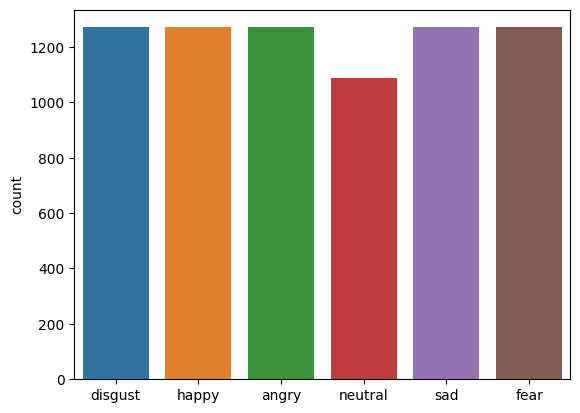

In [145]:
sns.countplot(x=label_emotion)

The dataset is well balanced.

In [146]:
# Encoding for model requirement

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
label_emotion = encoder.fit_transform(np.array(label_emotion).reshape(-1,1)).toarray()

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(speech_list,label_emotion, train_size = 0.8)

In [110]:
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [111]:
# Normalization of the input 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [134]:
model=Sequential()
model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_53 (Conv1D)          (None, 160, 256)          1536      
                                                                 
 max_pooling1d_51 (MaxPoolin  (None, 80, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 80, 256)           327936    
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 40, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_55 (Conv1D)          (None, 40, 128)           163968    
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 20, 128)        

In [135]:
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)
history=model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp,callback])

Epoch 1/50
373/373 [==============================] - 7s 17ms/step - loss: 1.6362 - accuracy: 0.3025 - val_loss: 1.5232 - val_accuracy: 0.3640 - lr: 0.0010
Epoch 2/50
373/373 [==============================] - 11s 28ms/step - loss: 1.5440 - accuracy: 0.3430 - val_loss: 1.5029 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 3/50
373/373 [==============================] - 11s 29ms/step - loss: 1.5106 - accuracy: 0.3719 - val_loss: 1.4932 - val_accuracy: 0.3465 - lr: 0.0010
Epoch 4/50
373/373 [==============================] - 11s 29ms/step - loss: 1.4848 - accuracy: 0.3855 - val_loss: 1.4591 - val_accuracy: 0.3848 - lr: 0.0010
Epoch 5/50
373/373 [==============================] - 11s 29ms/step - loss: 1.4579 - accuracy: 0.3953 - val_loss: 1.4411 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 6/50
373/373 [==============================] - 11s 29ms/step - loss: 1.4427 - accuracy: 0.4045 - val_loss: 1.4419 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 7/50
373/373 [==============================] - 11s 2

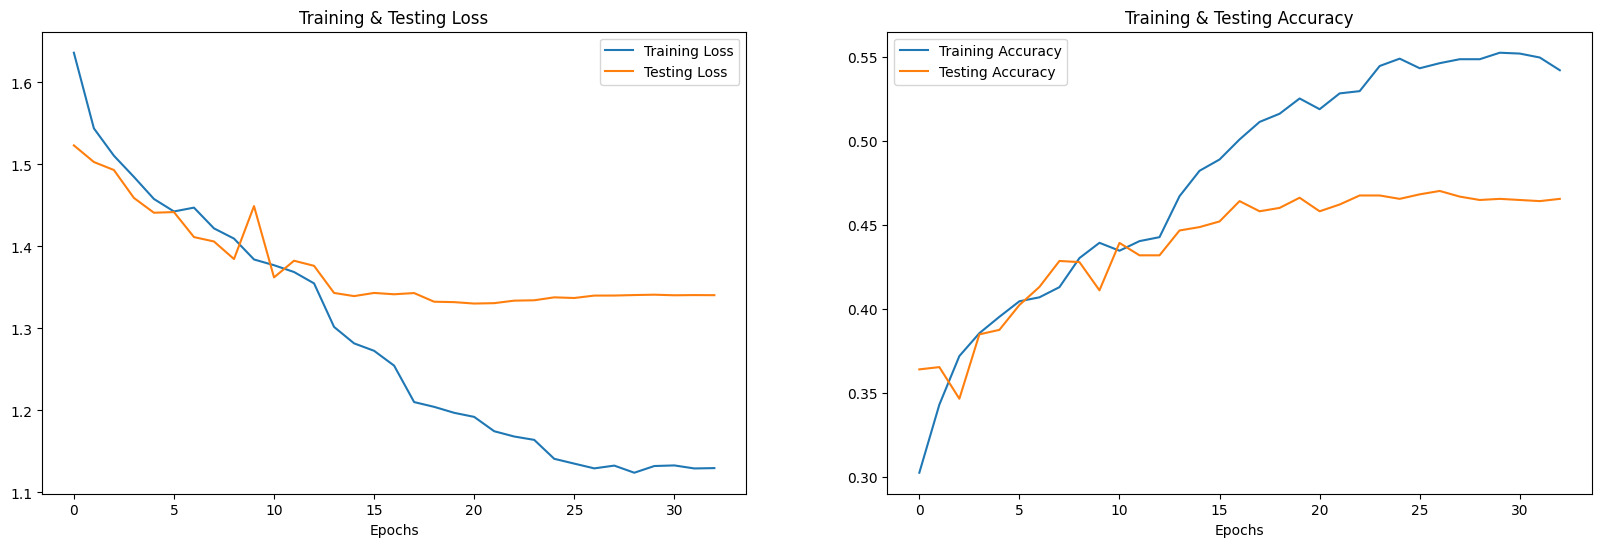

In [136]:
epochs = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()